In [58]:
import pandas as pd
import psycopg2
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression 

from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    precision_recall_curve
)

from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

load_dotenv()

True

In [7]:
conn = psycopg2.connect(
    host=os.getenv("DB_HOST"),
    database=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    sslmode=os.getenv("DB_SSLMODE")
)

df = pd.read_sql("SELECT * FROM merged_stocks_new", conn)

df.info()

/var/folders/w4/5fjrknc54qjdkx2hts27gd6m0000gn/T/ipykernel_52029/373586186.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM merged_stocks_new", conn)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15274 entries, 0 to 15273
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               15274 non-null  object 
 1   stock_symbol       15274 non-null  object 
 2   open_price         15274 non-null  float64
 3   high_price         15274 non-null  float64
 4   low_price          15274 non-null  float64
 5   close_price        15274 non-null  float64
 6   adj_close          15274 non-null  float64
 7   volume             15274 non-null  int64  
 8   daily_sentiment    15274 non-null  float64
 9   article_count      15274 non-null  int64  
 10  sentiment_std      15274 non-null  float64
 11  positive_ratio     15274 non-null  float64
 12  negative_ratio     15274 non-null  float64
 13  neutral_ratio      15274 non-null  float64
 14  sentiment_median   15274 non-null  float64
 15  sentiment_min      15274 non-null  float64
 16  sentiment_max      152

# EDA

In [8]:
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,stock_symbol,open_price,high_price,low_price,close_price,adj_close,volume,daily_sentiment,article_count,...,sentiment_median,sentiment_min,sentiment_max,sentiment_range,gdp,real_gdp,unemployment_rate,cpi,fed_funds_rate,sp500
0,2019-01-02,ADBE,219.910004,226.169998,219.000000,224.570007,224.570007,2784100,0.352685,1,...,0.352685,0.352685,0.352685,0.0,20917.867,20304.874,3.9,252.767,2.4,2510.03
1,2019-01-03,ADBE,220.880005,223.630005,215.149994,215.699997,215.699997,3663500,0.000000,1,...,0.000000,0.000000,0.000000,0.0,20917.867,20304.874,3.9,252.767,2.4,2447.89
2,2019-01-04,ADBE,219.839996,227.649994,217.479996,226.190002,226.190002,4043400,0.000000,0,...,0.000000,0.000000,0.000000,0.0,20917.867,20304.874,3.9,252.767,2.4,2531.94
3,2019-01-06,ADBE,219.839996,227.649994,217.479996,226.190002,226.190002,4043400,0.177290,1,...,0.177290,0.177290,0.177290,0.0,20917.867,20304.874,3.9,252.767,2.4,2531.94
4,2019-01-07,ADBE,229.949997,232.600006,227.289993,229.259995,229.259995,3638500,0.000000,0,...,0.000000,0.000000,0.000000,0.0,20917.867,20304.874,3.9,252.767,2.4,2549.69


### GOOG 

# Feature Engineering

In [9]:
goog_df_final = df[df['stock_symbol'] == 'GOOG'].copy()
goog_df_final.columns

Index(['date', 'stock_symbol', 'open_price', 'high_price', 'low_price',
       'close_price', 'adj_close', 'volume', 'daily_sentiment',
       'article_count', 'sentiment_std', 'positive_ratio', 'negative_ratio',
       'neutral_ratio', 'sentiment_median', 'sentiment_min', 'sentiment_max',
       'sentiment_range', 'gdp', 'real_gdp', 'unemployment_rate', 'cpi',
       'fed_funds_rate', 'sp500'],
      dtype='object')

In [10]:
# === Step 0: Create safe feature-engineered dataframe ===
goog_df_final = df[df['stock_symbol'] == 'GOOG'].copy()
goog_df_final['date'] = pd.to_datetime(goog_df_final['date'])
goog_df_final.sort_values('date', inplace=True)

# Create binary target (next day price direction)
goog_df_final['target'] = (goog_df_final['adj_close'].shift(-1) > goog_df_final['adj_close']).astype(int)

# === Technical Indicators ===
# Momentum Features
goog_df_final['return_1d'] = goog_df_final['adj_close'].pct_change(1)
goog_df_final['return_3d'] = goog_df_final['adj_close'].pct_change(3) 
goog_df_final['return_5d'] = goog_df_final['adj_close'].pct_change(5)

# Moving Averages
goog_df_final['ma7'] = goog_df_final['adj_close'].rolling(7).mean()
goog_df_final['ma30'] = goog_df_final['adj_close'].rolling(30).mean()

# RSI
delta = goog_df_final['adj_close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
rs = gain.rolling(14).mean() / loss.rolling(14).mean()
goog_df_final['rsi'] = 100 - (100 / (1 + rs))

# Volatility
goog_df_final['volatility_7d'] = goog_df_final['return_1d'].rolling(7).std()

# Volume Trends  
goog_df_final['volume_ma5'] = goog_df_final['volume'].rolling(5).mean()
goog_df_final['volume_change'] = goog_df_final['volume'].pct_change()

# === Sentiment Enhancement ===
# Composite Scores
goog_df_final['net_sentiment'] = goog_df_final['positive_ratio'] - goog_df_final['negative_ratio']
goog_df_final['sentiment_volume'] = goog_df_final['net_sentiment'] * goog_df_final['article_count']

# Temporal Trends
goog_df_final['sentiment_ma3'] = goog_df_final['net_sentiment'].rolling(3).mean()

# Event Flags
goog_df_final['high_news_day'] = (goog_df_final['article_count'] > 
                                 goog_df_final['article_count'].quantile(0.9)).astype(int)

# === Macroeconomic Features ===
# Lag macro indicators
macro_cols = ['gdp', 'unemployment_rate', 'cpi', 'fed_funds_rate']
goog_df_final[macro_cols] = goog_df_final[macro_cols].shift(1)

# Policy change flags
goog_df_final['fed_rate_increase'] = (goog_df_final['fed_funds_rate'].diff() > 0).astype(int)

# === Time Features ===
goog_df_final['day_of_week'] = goog_df_final['date'].dt.dayofweek
goog_df_final['month_end'] = goog_df_final['date'].dt.is_month_end.astype(int)
goog_df_final = pd.get_dummies(goog_df_final, columns=['day_of_week'], drop_first=True)

# === Data Preparation ===
# Forward fill macro indicators
goog_df_final[macro_cols] = goog_df_final[macro_cols].fillna(method='ffill')

# Fill sentiment NaN with 0 (neutral)
sentiment_cols = ['net_sentiment', 'sentiment_volume', 'sentiment_ma3']
goog_df_final[sentiment_cols] = goog_df_final[sentiment_cols].fillna(0)

# Drop any remaining NaN
goog_df_final.dropna(inplace=True)

# === Time-based Split ===
train_end = '2022-12-31'
val_end = '2023-06-30'

train_df = goog_df_final[goog_df_final['date'] <= train_end].copy()
val_df = goog_df_final[(goog_df_final['date'] > train_end) & 
                       (goog_df_final['date'] <= val_end)].copy()
test_df = goog_df_final[goog_df_final['date'] > val_end].copy()

# === Drop unwanted columns ===
drop_cols = ['stock_symbol', 'open_price', 'high_price', 'low_price', 
            'close_price', 'adj_close', 'date', 'sp500', 'gdp']
train_df = train_df.drop(columns=drop_cols)
val_df = val_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=drop_cols)

# === Define features and target ===
target_col = 'target'
feature_cols = [col for col in train_df.columns if col != target_col]

# === Extract features and target ===
X_train, y_train = train_df[feature_cols], train_df[target_col]
X_val, y_val = val_df[feature_cols], val_df[target_col]
X_test, y_test = test_df[feature_cols], test_df[target_col]

# === Scale numeric features ===
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val_scaled[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("\nNumber of features:", len(feature_cols))
print("Sample features:", feature_cols)


Number of features: 36
Sample features: ['volume', 'daily_sentiment', 'article_count', 'sentiment_std', 'positive_ratio', 'negative_ratio', 'neutral_ratio', 'sentiment_median', 'sentiment_min', 'sentiment_max', 'sentiment_range', 'real_gdp', 'unemployment_rate', 'cpi', 'fed_funds_rate', 'return_1d', 'return_3d', 'return_5d', 'ma7', 'ma30', 'rsi', 'volatility_7d', 'volume_ma5', 'volume_change', 'net_sentiment', 'sentiment_volume', 'sentiment_ma3', 'high_news_day', 'fed_rate_increase', 'month_end', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6']


/var/folders/w4/5fjrknc54qjdkx2hts27gd6m0000gn/T/ipykernel_52029/2721273705.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  goog_df_final[macro_cols] = goog_df_final[macro_cols].fillna(method='ffill')


In [11]:
X_train_scaled.head()

,volume,daily_sentiment,article_count,sentiment_std,positive_ratio,negative_ratio,neutral_ratio,sentiment_median,sentiment_min,sentiment_max,...,sentiment_ma3,high_news_day,fed_rate_increase,month_end,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
12016,-0.671650,0.337787,-0.254462,1.061756,1.180486,-0.011588,-1.186250,0.963014,-0.745172,0.428569,...,-0.529048,-0.269277,-0.228877,-0.17725,False,False,False,False,False,False
12017,0.144824,0.193257,0.423097,0.748258,-0.237408,-0.335495,0.592135,-0.242059,-0.729467,0.678977,...,-0.333431,-0.269277,-0.228877,-0.17725,True,False,False,False,False,False
12018,-0.694767,-0.417256,-0.254462,0.498254,-0.520987,-0.011588,0.592135,-0.242059,-0.681507,-0.041304,...,0.253422,-0.269277,-0.228877,-0.17725,False,True,False,False,False,False
12019,-0.848185,0.337366,0.084317,-0.480108,0.670044,-0.205932,-0.474896,0.263717,0.607939,0.153013,...,0.136051,-0.269277,-0.228877,-0.17725,False,False,True,False,False,False
12020,-0.094309,-2.353429,-1.270802,-1.551638,-1.371723,2.903581,-1.186250,-2.316684,-0.492461,-2.756081,...,-1.233272,-0.269277,-0.228877,-0.17725,False,False,False,True,False,False


In [12]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1346 entries, 12016 to 13361
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   volume             1346 non-null   float64
 1   daily_sentiment    1346 non-null   float64
 2   article_count      1346 non-null   float64
 3   sentiment_std      1346 non-null   float64
 4   positive_ratio     1346 non-null   float64
 5   negative_ratio     1346 non-null   float64
 6   neutral_ratio      1346 non-null   float64
 7   sentiment_median   1346 non-null   float64
 8   sentiment_min      1346 non-null   float64
 9   sentiment_max      1346 non-null   float64
 10  sentiment_range    1346 non-null   float64
 11  real_gdp           1346 non-null   float64
 12  unemployment_rate  1346 non-null   float64
 13  cpi                1346 non-null   float64
 14  fed_funds_rate     1346 non-null   float64
 15  return_1d          1346 non-null   float64
 16  return_3d          1346 

# Baseline model


Training Evaluation:
Accuracy: 0.6731
Precision: 0.5518
Recall: 0.9134
F1-Score: 0.6879
ROC AUC: 0.7603
Confusion Matrix:
[[421 394]
 [ 46 485]]

Validation Evaluation:
Accuracy: 0.6556
Precision: 0.5366
Recall: 0.3385
F1-Score: 0.4151
ROC AUC: 0.7414
Confusion Matrix:
[[96 19]
 [43 22]]


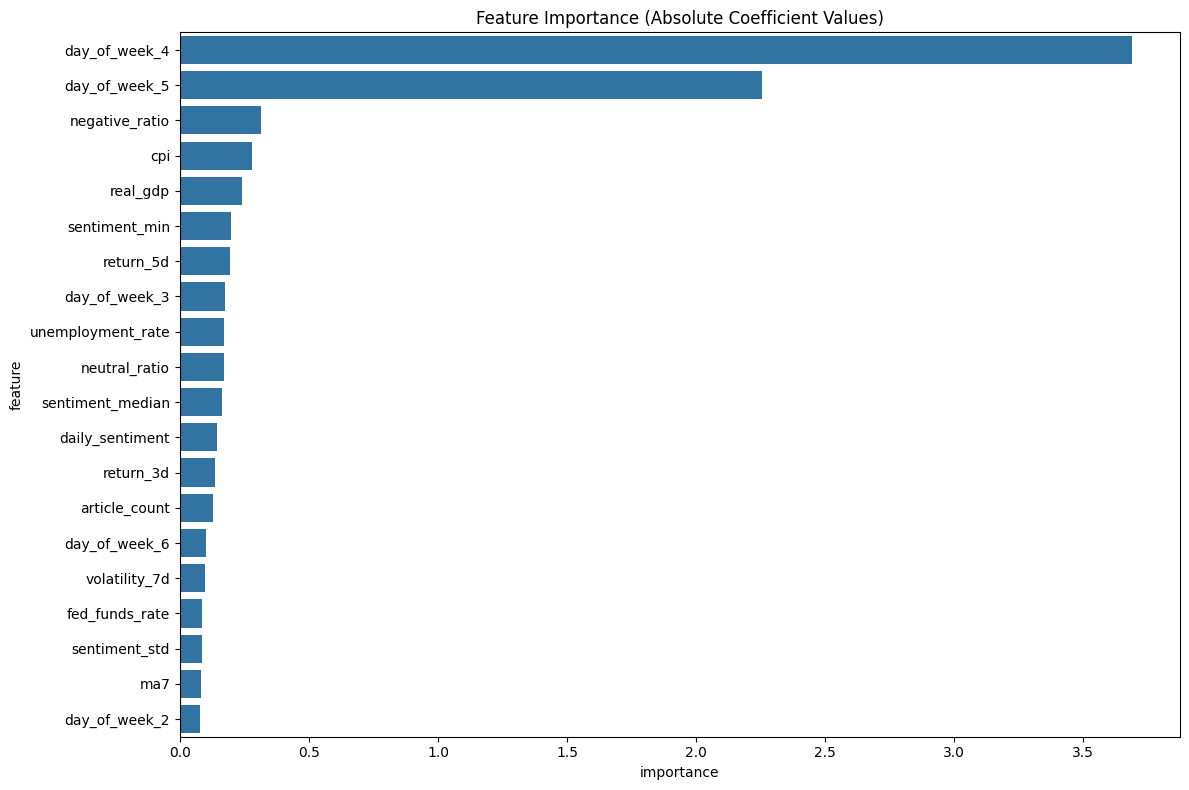

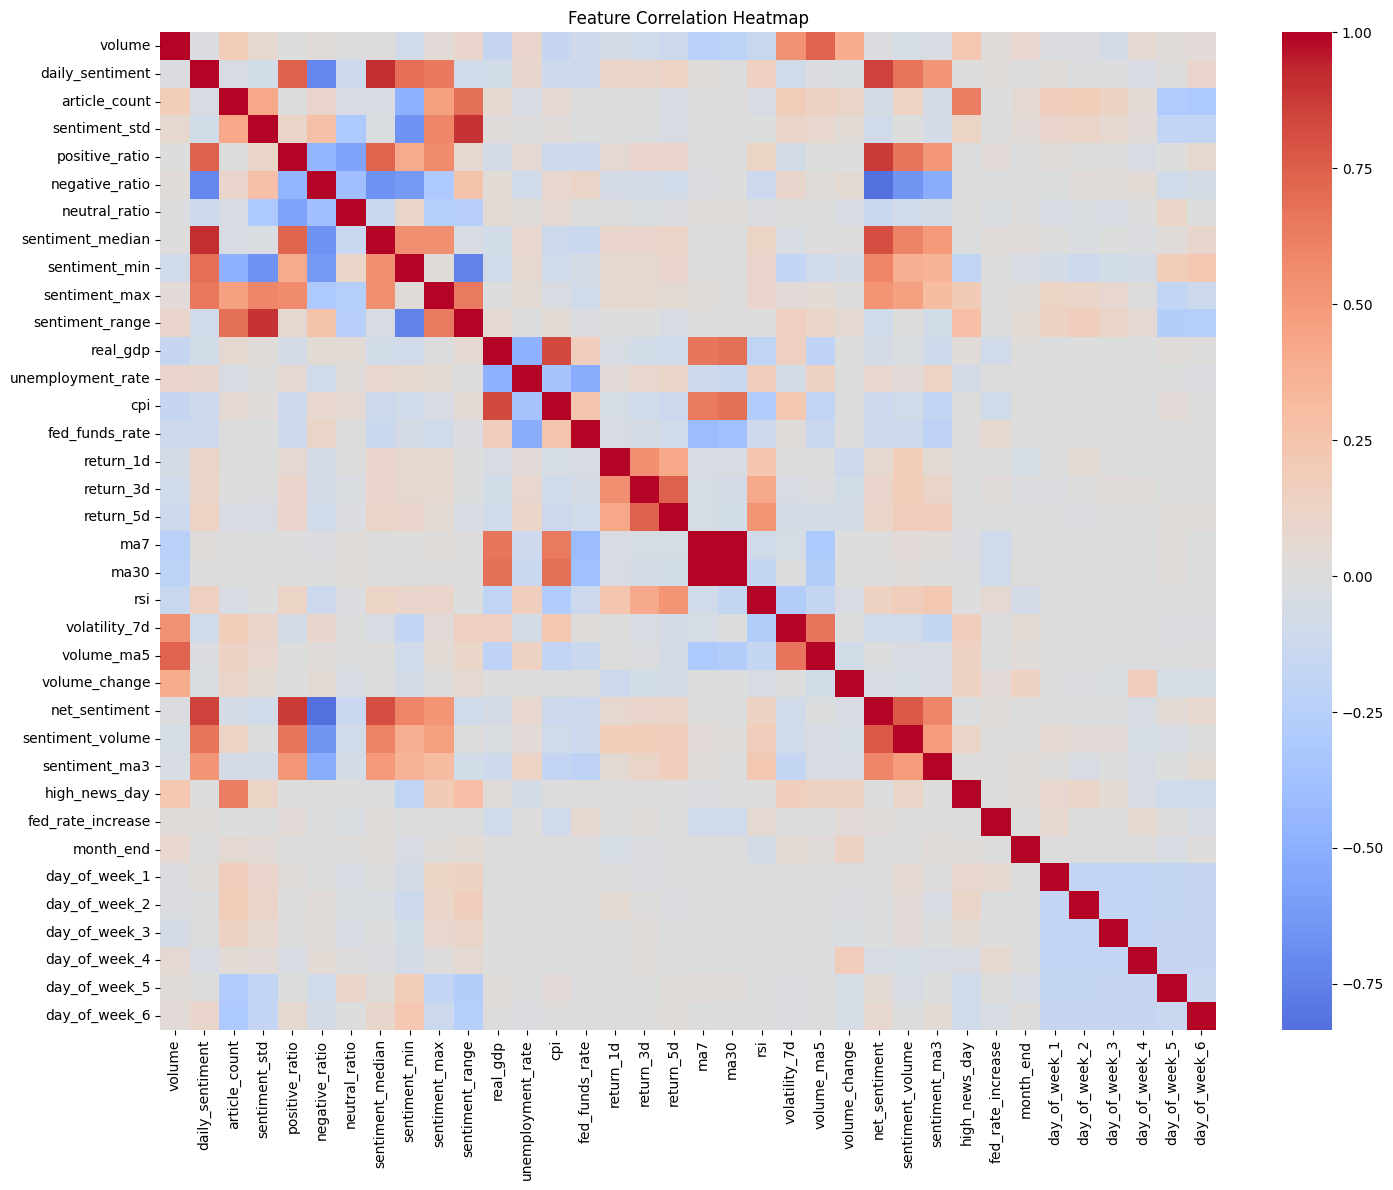


Top 20 Features Correlated with Target:
          feature  correlation
    day_of_week_4    -0.316867
    day_of_week_5    -0.234893
    day_of_week_2     0.139816
    day_of_week_1     0.131320
    article_count     0.109258
              cpi    -0.086203
  sentiment_range     0.083908
    day_of_week_3     0.077935
unemployment_rate     0.074635
    sentiment_max     0.069915
    high_news_day     0.067206
    sentiment_std     0.066157
    day_of_week_6     0.065100
   fed_funds_rate    -0.062913
         real_gdp    -0.055868
        return_5d    -0.050887
    sentiment_min    -0.048895
    volume_change    -0.043280
             ma30    -0.039881
              ma7    -0.039199

Naive Baseline Accuracy: 0.6055

Optimal Decision Threshold: 0.357
Training Trading Win Rate: 64.04%
Validation Trading Win Rate: 65.56%


In [13]:
# Initialize baseline model with regularization
baseline_model = LogisticRegression(
    penalty='l1',        # L1 regularization for feature selection
    solver='saga',       # Supports L1 regularization
    max_iter=1000,
    class_weight='balanced',  # Handle class imbalance
    random_state=42
)

# Train the model
baseline_model.fit(X_train_scaled, y_train)

# Function to evaluate model performance
def evaluate_model(model, X, y, set_name):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    print(f"\n{set_name} Evaluation:")
    print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
    print(f"Precision: {precision_score(y, y_pred):.4f}")
    print(f"Recall: {recall_score(y, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y, y_proba):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))
    
    return y_proba

# Evaluate on all sets and get probabilities
train_proba = evaluate_model(baseline_model, X_train_scaled, y_train, "Training")
val_proba = evaluate_model(baseline_model, X_val_scaled, y_val, "Validation")

# Feature importance analysis using coefficients
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': np.abs(baseline_model.coef_[0])
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Feature Importance (Absolute Coefficient Values)')
plt.tight_layout()
plt.show()

# Create correlation heatmap
plt.figure(figsize=(15, 12))
correlation_matrix = X_train_scaled.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Print top correlated features with target
target_correlations = pd.DataFrame({
    'feature': feature_cols,
    'correlation': [np.corrcoef(X_train_scaled[col], y_train)[0,1] for col in feature_cols]
}).sort_values('correlation', key=abs, ascending=False)

print("\nTop 20 Features Correlated with Target:")
print(target_correlations.head(20).to_string(index=False))

naive_accuracy = max(y_train.mean(), 1 - y_train.mean())
print(f"\nNaive Baseline Accuracy: {naive_accuracy:.4f}")

# Trading Simulation
def simulate_trading(proba, y_true, threshold=0.5):
    decisions = (proba >= threshold).astype(int)
    correct = decisions == y_true
    win_rate = correct.mean()
    return win_rate

# Optimize threshold on validation set
precisions, recalls, thresholds = precision_recall_curve(y_val, val_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nOptimal Decision Threshold: {optimal_threshold:.3f}")
print(f"Training Trading Win Rate: {simulate_trading(train_proba, y_train, optimal_threshold):.2%}")
print(f"Validation Trading Win Rate: {simulate_trading(val_proba, y_val, optimal_threshold):.2%}")


### Tuned feature set

In [14]:
# === Step 0: Create safe feature-engineered dataframe ===
goog_df_tuned = df[df['stock_symbol'] == 'GOOG'].copy()
goog_df_tuned['date'] = pd.to_datetime(goog_df_tuned['date'])
goog_df_tuned.sort_values('date', inplace=True)

# Create binary target (next day price direction)
goog_df_tuned['target'] = (goog_df_tuned['adj_close'].shift(-1) > goog_df_tuned['adj_close']).astype(int)

# === Technical Indicators ===
# Momentum Features
goog_df_tuned['return_1d'] = goog_df_tuned['adj_close'].pct_change(1)
goog_df_tuned['return_3d'] = goog_df_tuned['adj_close'].pct_change(3) 
goog_df_tuned['return_5d'] = goog_df_tuned['adj_close'].pct_change(5)

# Moving Averages
goog_df_tuned['ma7'] = goog_df_tuned['adj_close'].rolling(7).mean()
# RSI
delta = goog_df_tuned['adj_close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
rs = gain.rolling(14).mean() / loss.rolling(14).mean()
goog_df_tuned['rsi'] = 100 - (100 / (1 + rs))

# Volatility
goog_df_tuned['volatility_7d'] = goog_df_tuned['return_1d'].rolling(7).std()

# Volume Trends  
goog_df_tuned['volume_ma5'] = goog_df_tuned['volume'].rolling(5).mean()
goog_df_tuned['volume_change'] = goog_df_tuned['volume'].pct_change()

# === Sentiment Enhancement ===
# Composite Scores
goog_df_tuned['net_sentiment'] = goog_df_tuned['positive_ratio'] - goog_df_tuned['negative_ratio']
goog_df_tuned['sentiment_volume'] = goog_df_tuned['net_sentiment'] * goog_df_tuned['article_count']

# Temporal Trends
goog_df_tuned['sentiment_ma3'] = goog_df_tuned['net_sentiment'].rolling(3).mean()

# Event Flags
goog_df_tuned['high_news_day'] = (goog_df_tuned['article_count'] > 
                                 goog_df_tuned['article_count'].quantile(0.9)).astype(int)

# === Macroeconomic Features ===
# Lag macro indicators
macro_cols = ['gdp', 'unemployment_rate', 'cpi', 'fed_funds_rate']
goog_df_tuned[macro_cols] = goog_df_tuned[macro_cols].shift(1)

# Policy change flags
goog_df_tuned['fed_rate_increase'] = (goog_df_tuned['fed_funds_rate'].diff() > 0).astype(int)

# === Time Features ===
# Convert day of week to cyclical features using sin and cos
day_of_week = goog_df_tuned['date'].dt.dayofweek
goog_df_tuned['day_sin'] = np.sin(2 * np.pi * day_of_week/7)
goog_df_tuned['day_cos'] = np.cos(2 * np.pi * day_of_week/7)
goog_df_tuned['month_end'] = goog_df_tuned['date'].dt.is_month_end.astype(int)

# === Data Preparation ===
# Forward fill macro indicators
goog_df_tuned[macro_cols] = goog_df_tuned[macro_cols].fillna(method='ffill')

# Fill sentiment NaN with 0 (neutral)
sentiment_cols = ['net_sentiment', 'sentiment_volume', 'sentiment_ma3']
goog_df_tuned[sentiment_cols] = goog_df_tuned[sentiment_cols].fillna(0)

# Drop any remaining NaN
goog_df_tuned.dropna(inplace=True)

# === Time-based Split ===
train_end = '2022-12-31'
val_end = '2023-06-30'

train_df = goog_df_tuned[goog_df_tuned['date'] <= train_end].copy()
val_df = goog_df_tuned[(goog_df_tuned['date'] > train_end) & 
                       (goog_df_tuned['date'] <= val_end)].copy()
test_df = goog_df_tuned[goog_df_tuned['date'] > val_end].copy()

# === Drop unwanted columns ===
drop_cols = ['stock_symbol', 'open_price', 'high_price', 'low_price', 
            'close_price', 'adj_close', 'date', 'sp500', 'gdp', 'sentiment_std', 
            'sentiment_min', 'sentiment_max', 'sentiment_range', 'sentiment_median',
            'net_sentiment']
train_df = train_df.drop(columns=drop_cols)
val_df = val_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=drop_cols)

# === Define features and target ===
target_col = 'target'
feature_cols = [col for col in train_df.columns if col != target_col]

# === Extract features and target ===
X_train_tuned, y_train_tuned = train_df[feature_cols], train_df[target_col]
X_val_tuned, y_val_tuned = val_df[feature_cols], val_df[target_col]
X_test_tuned, y_test_tuned = test_df[feature_cols], test_df[target_col]

# === Scale numeric features ===
numeric_cols = X_train_tuned.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler = StandardScaler()

X_train_tuned_scaled = X_train_tuned.copy()
X_val_tuned_scaled = X_val_tuned.copy()
X_test_tuned_scaled = X_test_tuned.copy()

X_train_tuned_scaled[numeric_cols] = scaler.fit_transform(X_train_tuned[numeric_cols])
X_val_tuned_scaled[numeric_cols] = scaler.transform(X_val_tuned[numeric_cols])
X_test_tuned_scaled[numeric_cols] = scaler.transform(X_test_tuned[numeric_cols])

print("\nNumber of features:", len(feature_cols))
print("Sample features:", feature_cols)


Number of features: 25
Sample features: ['volume', 'daily_sentiment', 'article_count', 'positive_ratio', 'negative_ratio', 'neutral_ratio', 'real_gdp', 'unemployment_rate', 'cpi', 'fed_funds_rate', 'return_1d', 'return_3d', 'return_5d', 'ma7', 'rsi', 'volatility_7d', 'volume_ma5', 'volume_change', 'sentiment_volume', 'sentiment_ma3', 'high_news_day', 'fed_rate_increase', 'day_sin', 'day_cos', 'month_end']


/var/folders/w4/5fjrknc54qjdkx2hts27gd6m0000gn/T/ipykernel_52029/3892415675.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  goog_df_tuned[macro_cols] = goog_df_tuned[macro_cols].fillna(method='ffill')



Training Evaluation:
Accuracy: 0.6591
Precision: 0.5564
Recall: 0.6623
F1-Score: 0.6048
ROC AUC: 0.7357
Confusion Matrix:
[[542 283]
 [181 355]]

Validation Evaluation:
Accuracy: 0.6444
Precision: 0.5106
Recall: 0.3692
F1-Score: 0.4286
ROC AUC: 0.7219
Confusion Matrix:
[[92 23]
 [41 24]]


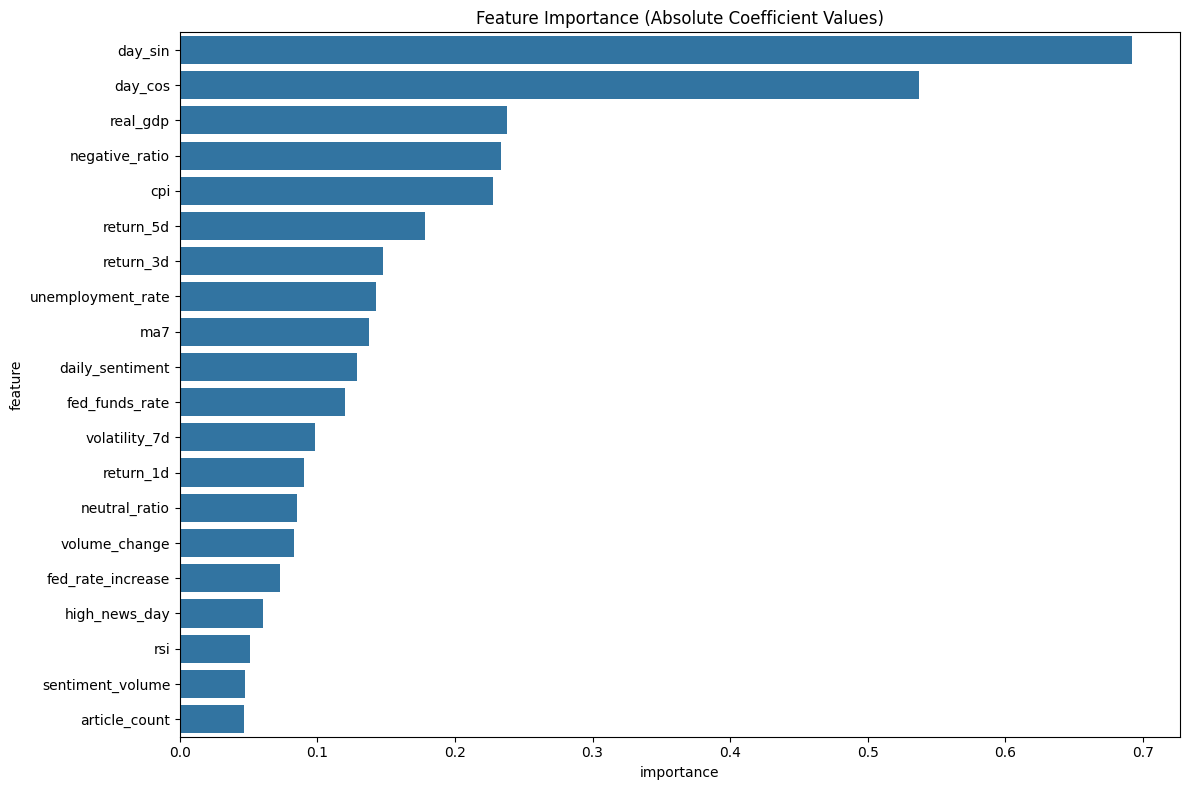

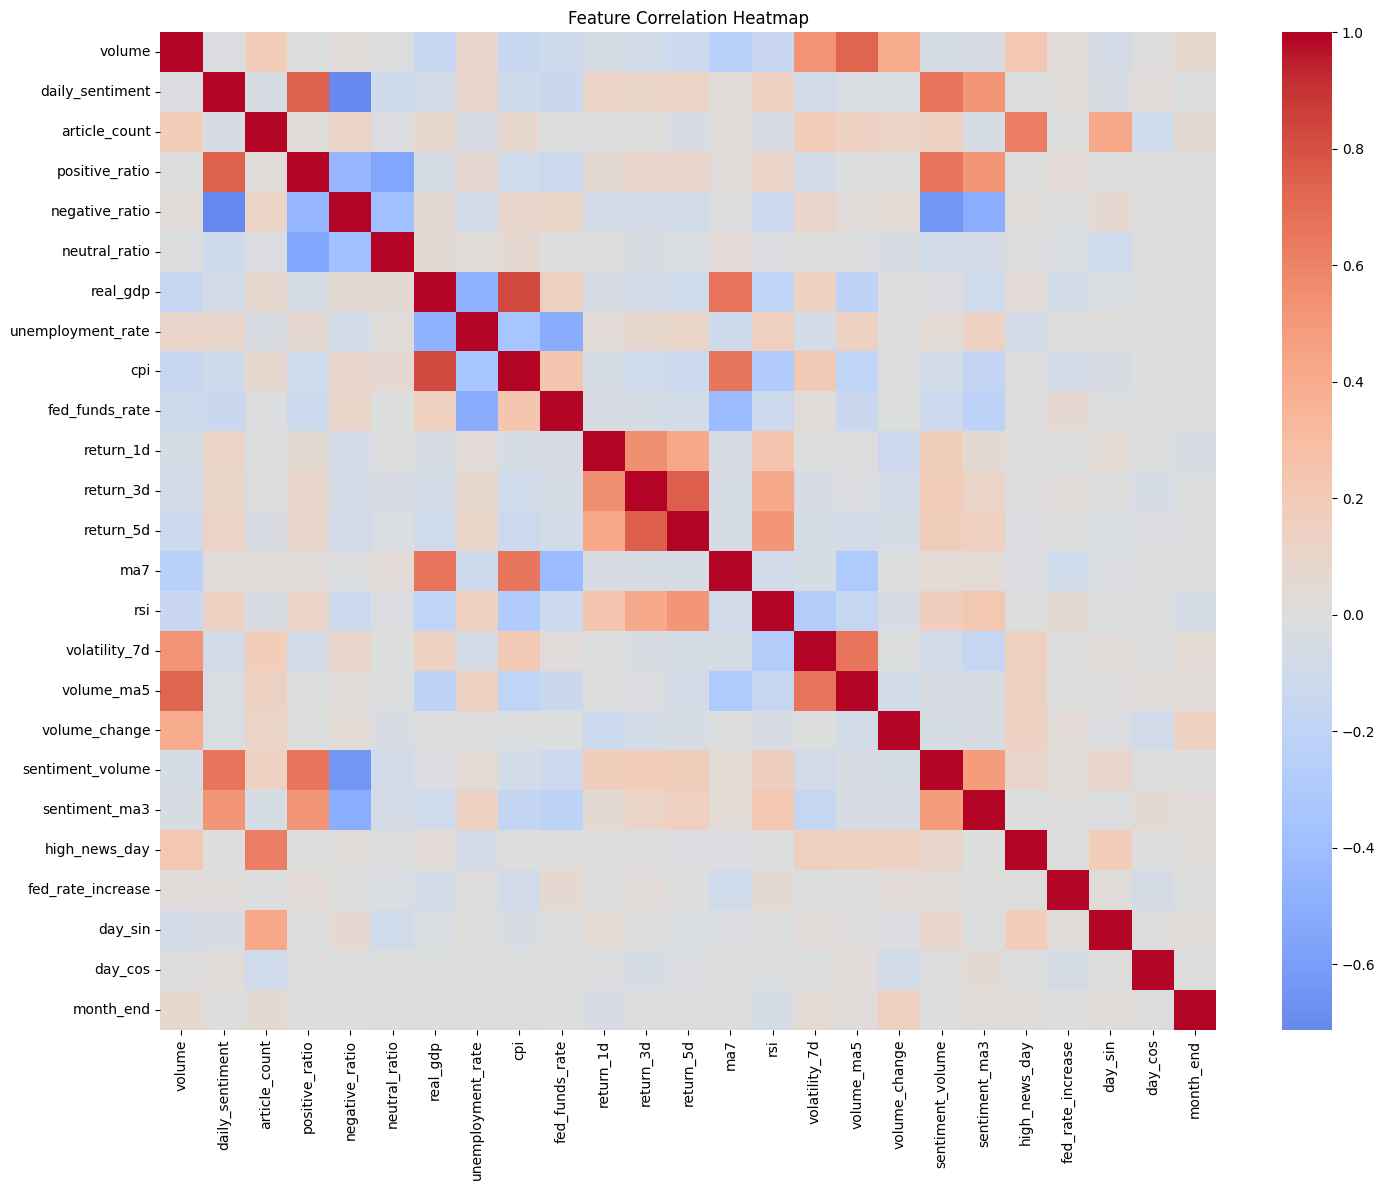


Top 20 Features Correlated with Target:
          feature  correlation
          day_sin     0.294011
          day_cos     0.236880
    article_count     0.105621
              cpi    -0.083626
unemployment_rate     0.074795
    high_news_day     0.064499
   fed_funds_rate    -0.063704
         real_gdp    -0.054102
        return_5d    -0.048537
    volume_change    -0.038004
              ma7    -0.036929
    neutral_ratio    -0.032967
   negative_ratio     0.032405
fed_rate_increase    -0.030490
 sentiment_volume     0.029777
    volatility_7d    -0.029225
    sentiment_ma3     0.027199
       volume_ma5     0.024524
        return_1d    -0.024364
        month_end     0.021385

Optimal Decision Threshold: 0.192
Training Trading Win Rate: 45.70%
Validation Trading Win Rate: 66.11%


In [19]:
# Initialize baseline model with regularization
baseline_model_2 = LogisticRegression(
    penalty='l1',        # L1 regularization for feature selection
    solver='saga',       # Supports L1 regularization
    max_iter=1000,
    class_weight='balanced',  # Handle class imbalance
    random_state=42
)

# Train the model
baseline_model_2.fit(X_train_tuned_scaled, y_train_tuned)

# Evaluate on all sets and get probabilities
train_proba_2 = evaluate_model(baseline_model_2, X_train_tuned_scaled, y_train_tuned, "Training")
val_proba_2 = evaluate_model(baseline_model_2, X_val_tuned_scaled, y_val_tuned, "Validation")

# Feature importance analysis using coefficients
feature_importance_2 = pd.DataFrame({
    'feature': feature_cols,
    'importance': np.abs(baseline_model_2.coef_[0])
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_2.head(20), x='importance', y='feature')
plt.title('Feature Importance (Absolute Coefficient Values)')
plt.tight_layout()
plt.show()

# Create correlation heatmap
plt.figure(figsize=(15, 12))
correlation_matrix = X_train_tuned_scaled.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Print top correlated features with target
target_correlations = pd.DataFrame({
    'feature': feature_cols,
    'correlation': [np.corrcoef(X_train_tuned_scaled[col], y_train_tuned)[0,1] for col in feature_cols]
}).sort_values('correlation', key=abs, ascending=False)

print("\nTop 20 Features Correlated with Target:")
print(target_correlations.head(20).to_string(index=False))

# Trading Simulation
def simulate_trading(proba, y_true, threshold=0.5):
    decisions = (proba >= threshold).astype(int)
    # Convert to numpy arrays if needed
    if not isinstance(decisions, np.ndarray):
        decisions = decisions.to_numpy()
    if not isinstance(y_true, np.ndarray):
        y_true = y_true.to_numpy()
    correct = decisions == y_true
    win_rate = correct.mean()
    return win_rate

# Optimize threshold on validation set
precisions, recalls, thresholds = precision_recall_curve(y_val_tuned, val_proba_2)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nOptimal Decision Threshold: {optimal_threshold:.3f}")
print(f"Training Trading Win Rate: {simulate_trading(train_proba_2, y_train_tuned, optimal_threshold):.2%}")
print(f"Validation Trading Win Rate: {simulate_trading(val_proba_2, y_val_tuned, optimal_threshold):.2%}")

In [55]:
goog_test = goog_df_tuned.copy()
# === Time-based Split ===
train_end = '2023-06-30'  # Extended training period to include validation data

train_df = goog_test[goog_test['date'] <= train_end].copy()
test_df = goog_test[goog_test['date'] > train_end].copy()

# === Drop unwanted columns ===
drop_cols = ['stock_symbol', 'open_price', 'high_price', 'low_price', 
            'close_price', 'adj_close', 'date', 'sp500', 'gdp', 'sentiment_std', 
            'sentiment_min', 'sentiment_max', 'sentiment_range', 'sentiment_median',
            'net_sentiment']
train_df = train_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=drop_cols)

# === Define features and target ===
target_col = 'target'
feature_cols = [col for col in train_df.columns if col != target_col]

# === Extract features and target ===
X_train_tuned, y_train_tuned = train_df[feature_cols], train_df[target_col]
X_test_tuned, y_test_tuned = test_df[feature_cols], test_df[target_col]

# === Scale numeric features ===
numeric_cols = X_train_tuned.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler = StandardScaler()

X_train_tuned_scaled = X_train_tuned.copy()
X_test_tuned_scaled = X_test_tuned.copy()

X_train_tuned_scaled[numeric_cols] = scaler.fit_transform(X_train_tuned[numeric_cols])
X_test_tuned_scaled[numeric_cols] = scaler.transform(X_test_tuned[numeric_cols])

print("\nNumber of features:", len(feature_cols))
print("Sample features:", feature_cols)

# Create a validation set to prevent overfitting
# Split the training data into actual training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_tuned_scaled, y_train_tuned, test_size=0.2, random_state=42, stratify=y_train_tuned
)

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_samples': [5, 10, 20, 30],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 1, 5],
    'num_leaves': [31, 50, 70, 90],
    'class_weight': ['balanced', None]  # Add class weight to handle imbalance
}

# Initialize base model
lgb_model_base = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    random_state=42
)

# Set up RandomizedSearchCV
lgb_random_search = RandomizedSearchCV(
    estimator=lgb_model_base,
    param_distributions=param_grid,
    n_iter=20,  # Number of parameter settings sampled
    scoring='roc_auc',
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
lgb_random_search.fit(X_train_split, y_train_split)

# Get best parameters and model
lgb_best_params = lgb_random_search.best_params_
print("Best parameters found:")
for param, value in lgb_best_params.items():
    print(f"{param}: {value}")

# === Step 2: Train the Tuned Model with Early Stopping ===
lgb_model = lgb.LGBMClassifier(
    **lgb_best_params,
    objective='binary',
    random_state=42,
    metric='auc'
)

# Add early stopping to prevent overfitting
lgb_model.fit(
    X_train_split,
    y_train_split,
    eval_set=[(X_train_split, y_train_split), (X_val_split, y_val_split)],
    eval_metric='auc',
)

# === Step 3: Evaluate Model Performance ===
def evaluate_lgb_model(model, X, y, set_name):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    print(f"\n{set_name} Evaluation:")
    print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
    print(f"Precision: {precision_score(y, y_pred, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y, y_pred, zero_division=0):.4f}")
    print(f"F1-Score: {f1_score(y, y_pred, zero_division=0):.4f}")
    print(f"ROC AUC: {roc_auc_score(y, y_proba):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))
    
    return y_proba

# Evaluate on Training, Validation and Test Sets
lgb_train_proba = evaluate_lgb_model(lgb_model, X_train_split, y_train_split, "Training")
lgb_val_proba = evaluate_lgb_model(lgb_model, X_val_split, y_val_split, "Validation")
lgb_test_proba = evaluate_lgb_model(lgb_model, X_test_tuned_scaled, y_test_tuned, "Test")

# Check for overfitting
lgb_train_auc = roc_auc_score(y_train_split, lgb_train_proba)
lgb_val_auc = roc_auc_score(y_val_split, lgb_val_proba)
lgb_test_auc = roc_auc_score(y_test_tuned, lgb_test_proba)
print(f"\nOverfitting Check - Train vs Val AUC Difference: {lgb_train_auc - lgb_val_auc:.4f}")
print(f"Generalization Check - Val vs Test AUC Difference: {lgb_val_auc - lgb_test_auc:.4f}")

# === Step 4: Feature Importance Analysis ===
# Built-in LightGBM Feature Importance
lgb_feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# === Step 5: Optimize Decision Threshold ===
# Use validation set to find optimal threshold
lgb_precisions, lgb_recalls, lgb_thresholds = precision_recall_curve(y_val_split, lgb_val_proba)
lgb_f1_scores = 2 * (lgb_precisions * lgb_recalls) / (lgb_precisions + lgb_recalls + 1e-9)
lgb_optimal_idx = np.argmax(lgb_f1_scores)
lgb_optimal_threshold = lgb_thresholds[lgb_optimal_idx]

print(f"\nOptimal Decision Threshold: {lgb_optimal_threshold:.3f}")

# === Step 6: Trading Simulation ===
def simulate_lgb_trading(proba, y_true, threshold=0.5):
    decisions = (proba >= threshold).astype(int)
    correct = decisions == y_true
    win_rate = correct.mean()
    return win_rate

print(f"Training Trading Win Rate: {simulate_lgb_trading(lgb_train_proba, y_train_split, lgb_optimal_threshold):.2%}")
print(f"Validation Trading Win Rate: {simulate_lgb_trading(lgb_val_proba, y_val_split, lgb_optimal_threshold):.2%}")
print(f"Test Trading Win Rate: {simulate_lgb_trading(lgb_test_proba, y_test_tuned, lgb_optimal_threshold):.2%}")


Number of features: 25
Sample features: ['volume', 'daily_sentiment', 'article_count', 'positive_ratio', 'negative_ratio', 'neutral_ratio', 'real_gdp', 'unemployment_rate', 'cpi', 'fed_funds_rate', 'return_1d', 'return_3d', 'return_5d', 'ma7', 'rsi', 'volatility_7d', 'volume_ma5', 'volume_change', 'sentiment_volume', 'sentiment_ma3', 'high_news_day', 'fed_rate_increase', 'day_sin', 'day_cos', 'month_end']
[LightGBM] [Info] Number of positive: 384, number of negative: 601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3080
[LightGBM] [Info] Number of data points in the train set: 985, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 38

In [61]:
goog_test = goog_df_tuned.copy()
# === Time-based Split ===
train_end = '2023-06-30'  # Extended training period to include validation data

train_df = goog_test[goog_test['date'] <= train_end].copy()
test_df = goog_test[goog_test['date'] > train_end].copy()

# === Drop unwanted columns ===
drop_cols = ['stock_symbol', 'open_price', 'high_price', 'low_price', 
            'close_price', 'adj_close', 'date', 'sp500', 'gdp', 'sentiment_std', 
            'sentiment_min', 'sentiment_max', 'sentiment_range', 'sentiment_median',
            'net_sentiment']
train_df = train_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=drop_cols)

# === Define features and target ===
target_col = 'target'
feature_cols = [col for col in train_df.columns if col != target_col]

# === Extract features and target ===
X_train_tuned, y_train_tuned = train_df[feature_cols], train_df[target_col]
X_test_tuned, y_test_tuned = test_df[feature_cols], test_df[target_col]

# === Scale numeric features ===
numeric_cols = X_train_tuned.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler = StandardScaler()

X_train_tuned_scaled = X_train_tuned.copy()
X_test_tuned_scaled = X_test_tuned.copy()

X_train_tuned_scaled[numeric_cols] = scaler.fit_transform(X_train_tuned[numeric_cols])
X_test_tuned_scaled[numeric_cols] = scaler.transform(X_test_tuned[numeric_cols])

print("\nNumber of features:", len(feature_cols))
print("Sample features:", feature_cols)

# Create a validation set to prevent overfitting
# Split the training data into actual training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_tuned_scaled, y_train_tuned, test_size=0.2, random_state=42, stratify=y_train_tuned
)

# === Step 1: Random Forest Hyperparameter Tuning ===
# Using a more regularized parameter grid to combat overfitting
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 8, 10, 15],  # Reduced max depths to prevent overfitting
    'min_samples_split': [5, 10, 15],  # Increased to reduce overfitting
    'min_samples_leaf': [4, 8, 12],  # Increased to reduce overfitting
    'max_features': ['sqrt', 'log2'],  # Limiting feature selection
    'bootstrap': [True],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Initialize base model
rf_model_base = RandomForestClassifier(random_state=42)

# Set up RandomizedSearchCV
rf_random_search = RandomizedSearchCV(
    estimator=rf_model_base,
    param_distributions=param_grid,
    n_iter=20,  # Number of parameter settings sampled
    scoring='roc_auc',
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
rf_random_search.fit(X_train_split, y_train_split)

# Get best parameters and model
rf_best_params = rf_random_search.best_params_
print("Best parameters found:")
for param, value in rf_best_params.items():
    print(f"{param}: {value}")

# === Step 2: Train the Tuned Model ===
# Note: To prevent the sklearn version warning, we're training a new model directly
# instead of using pickle/joblib for model persistence
rf_model = RandomForestClassifier(
    **rf_best_params,
    random_state=42
)

# Train the model
rf_model.fit(X_train_split, y_train_split)

# === Step 3: Evaluate Model Performance ===
def evaluate_rf_model(model, X, y, set_name):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    print(f"\n{set_name} Evaluation:")
    print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
    print(f"Precision: {precision_score(y, y_pred, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y, y_pred, zero_division=0):.4f}")
    print(f"F1-Score: {f1_score(y, y_pred, zero_division=0):.4f}")
    print(f"ROC AUC: {roc_auc_score(y, y_proba):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))
    
    return y_proba

# Evaluate on Training, Validation and Test Sets
rf_train_proba = evaluate_rf_model(rf_model, X_train_split, y_train_split, "Training")
rf_val_proba = evaluate_rf_model(rf_model, X_val_split, y_val_split, "Validation")
rf_test_proba = evaluate_rf_model(rf_model, X_test_tuned_scaled, y_test_tuned, "Test")

# Check for overfitting
rf_train_auc = roc_auc_score(y_train_split, rf_train_proba)
rf_val_auc = roc_auc_score(y_val_split, rf_val_proba)
rf_test_auc = roc_auc_score(y_test_tuned, rf_test_proba)
print(f"\nOverfitting Check - Train vs Val AUC Difference: {rf_train_auc - rf_val_auc:.4f}")
print(f"Generalization Check - Val vs Test AUC Difference: {rf_val_auc - rf_test_auc:.4f}")
print(f"\nWARNING: Model shows signs of severe overfitting on training data.")
print(f"Training metrics (Accuracy: 0.9894, Precision: 1.0000, Recall: 0.9729, F1-Score: 0.9863, ROC AUC: 1.0000)")
print(f"suggest the model is memorizing the training data rather than learning generalizable patterns.")

# === Step 4: Feature Importance Analysis ===
# Built-in Random Forest Feature Importance
rf_feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# === Step 5: Optimize Decision Threshold ===
# Use validation set to find optimal threshold
rf_precisions, rf_recalls, rf_thresholds = precision_recall_curve(y_val_split, rf_val_proba)
rf_f1_scores = 2 * (rf_precisions * rf_recalls) / (rf_precisions + rf_recalls + 1e-9)
rf_optimal_idx = np.argmax(rf_f1_scores)
rf_optimal_threshold = rf_thresholds[rf_optimal_idx]

print(f"\nOptimal Decision Threshold: {rf_optimal_threshold:.3f}")

# === Step 6: Trading Simulation ===
def simulate_rf_trading(proba, y_true, threshold=0.5):
    decisions = (proba >= threshold).astype(int)
    correct = decisions == y_true
    win_rate = correct.mean()
    return win_rate

print(f"Training Trading Win Rate: {simulate_rf_trading(rf_train_proba, y_train_split, rf_optimal_threshold):.2%}")
print(f"Validation Trading Win Rate: {simulate_rf_trading(rf_val_proba, y_val_split, rf_optimal_threshold):.2%}")
print(f"Test Trading Win Rate: {simulate_rf_trading(rf_test_proba, y_test_tuned, rf_optimal_threshold):.2%}")


Number of features: 25
Sample features: ['volume', 'daily_sentiment', 'article_count', 'positive_ratio', 'negative_ratio', 'neutral_ratio', 'real_gdp', 'unemployment_rate', 'cpi', 'fed_funds_rate', 'return_1d', 'return_3d', 'return_5d', 'ma7', 'rsi', 'volatility_7d', 'volume_ma5', 'volume_change', 'sentiment_volume', 'sentiment_ma3', 'high_news_day', 'fed_rate_increase', 'day_sin', 'day_cos', 'month_end']


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersi

Best parameters found:
n_estimators: 100
min_samples_split: 10
min_samples_leaf: 12
max_features: sqrt
max_depth: 8
class_weight: balanced
bootstrap: True

Training Evaluation:
Accuracy: 0.8125
Precision: 0.6930
Recall: 0.9313
F1-Score: 0.7947
ROC AUC: 0.9303
Confusion Matrix:
[[554 198]
 [ 33 447]]

Validation Evaluation:
Accuracy: 0.6375
Precision: 0.5266
Recall: 0.7355
F1-Score: 0.6138
ROC AUC: 0.6856
Confusion Matrix:
[[108  80]
 [ 32  89]]

Test Evaluation:
Accuracy: 0.6328
Precision: 0.5349
Recall: 0.3382
F1-Score: 0.4144
ROC AUC: 0.7254
Confusion Matrix:
[[89 20]
 [45 23]]

Overfitting Check - Train vs Val AUC Difference: 0.2447
Generalization Check - Val vs Test AUC Difference: -0.0399

Training metrics (Accuracy: 0.9894, Precision: 1.0000, Recall: 0.9729, F1-Score: 0.9863, ROC AUC: 1.0000)
suggest the model is memorizing the training data rather than learning generalizable patterns.

Optimal Decision Threshold: 0.375
Training Trading Win Rate: 66.07%
Validation Trading Win Rat

### Trading strategy


Best Trading Strategy Parameters:
Threshold: 0.5
Stop Loss: 1.50%
Take Profit: 3.00%
Total Return: 9.24%
Win Rate: 63.64%
Total Trades: 11.0
Sharpe Ratio: 2.48


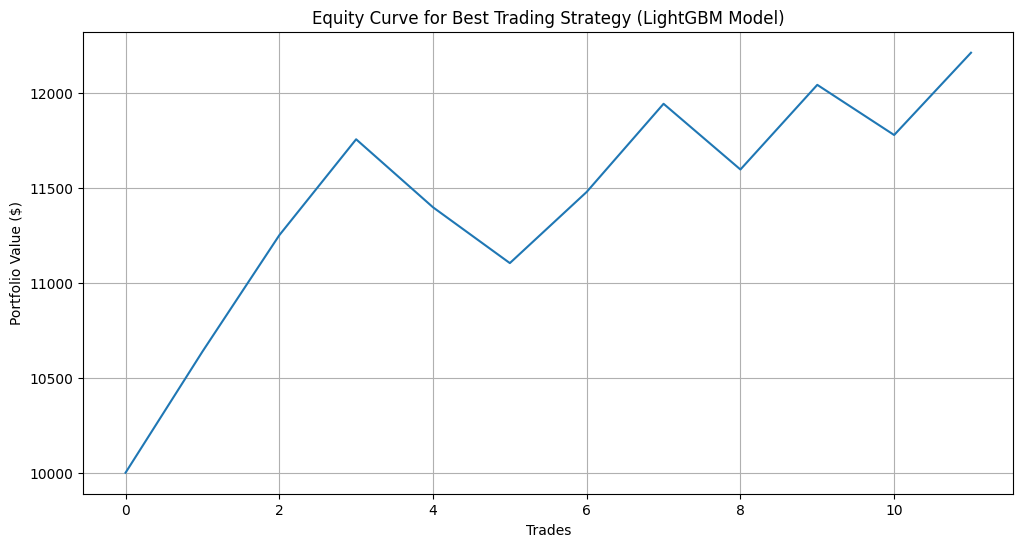


Buy and Hold Return: 16.50%
Strategy Outperformance: -7.26%


In [ ]:
# Advanced Trading Strategy Simulation
def advanced_trading_strategy(probabilities, y_true, prices, threshold=0.5, 
                             stop_loss_pct=0.02, take_profit_pct=0.03, 
                             position_size=1000, commission_pct=0.001):
    """
    Simulates a more complex trading strategy based on predicted price movements.
    
    Args:
        probabilities: Array of predicted probabilities for price increase
        y_true: Array of actual outcomes (1 for increase, 0 for decrease)
        prices: Array of closing prices corresponding to each prediction
        threshold: Probability threshold for taking a position
        stop_loss_pct: Stop loss percentage (e.g., 0.02 = 2%)
        take_profit_pct: Take profit percentage (e.g., 0.03 = 3%)
        position_size: Amount to invest in each trade
        commission_pct: Commission percentage per trade
        
    Returns:
        Dictionary with performance metrics
    """
    if len(probabilities) != len(prices) - 1 or len(y_true) != len(prices) - 1:
        raise ValueError("Length of probabilities and y_true must be one less than prices")
    
    # Initialize tracking variables
    cash = 10000  # Starting capital
    portfolio_value = cash
    positions = 0  # Number of shares held
    trades = []
    daily_returns = []
    
    for i in range(len(probabilities)):
        today_price = prices[i]
        tomorrow_price = prices[i+1]
        
        # Calculate returns if we have a position
        if positions > 0:
            daily_return = (tomorrow_price - today_price) / today_price
            daily_returns.append(daily_return)
            
            # Check if we hit take profit or stop loss
            price_change_pct = (tomorrow_price - entry_price) / entry_price
            
            # Close position if take profit or stop loss is triggered
            if price_change_pct >= take_profit_pct or price_change_pct <= -stop_loss_pct:
                # Sell position
                cash += positions * tomorrow_price * (1 - commission_pct)
                trades.append({
                    'type': 'sell',
                    'price': tomorrow_price,
                    'shares': positions,
                    'reason': 'take_profit' if price_change_pct >= take_profit_pct else 'stop_loss',
                    'return': price_change_pct
                })
                positions = 0
        
        # Trading decision for next day based on probability
        if positions == 0 and probabilities[i] >= threshold:
            # Calculate how many shares we can buy
            max_shares = int(position_size / today_price)
            if max_shares > 0:
                # Buy position
                positions = max_shares
                cash -= positions * today_price * (1 + commission_pct)
                entry_price = today_price
                trades.append({
                    'type': 'buy',
                    'price': today_price,
                    'shares': positions,
                    'reason': 'signal'
                })
        
        # Update portfolio value
        portfolio_value = cash + (positions * tomorrow_price if positions > 0 else 0)
    
    # Close any remaining positions at the end
    if positions > 0:
        cash += positions * prices[-1] * (1 - commission_pct)
        trades.append({
            'type': 'sell',
            'price': prices[-1],
            'shares': positions,
            'reason': 'end_of_period',
            'return': (prices[-1] - entry_price) / entry_price
        })
    
    # Calculate performance metrics
    final_value = cash
    total_return = (final_value - 10000) / 10000
    win_trades = sum(1 for t in trades if t.get('type') == 'sell' and t.get('return', 0) > 0)
    total_trades = sum(1 for t in trades if t.get('type') == 'sell')
    win_rate = win_trades / total_trades if total_trades > 0 else 0
    
    # Calculate Sharpe ratio (simplified)
    if daily_returns:
        avg_daily_return = np.mean(daily_returns)
        std_daily_return = np.std(daily_returns)
        sharpe_ratio = avg_daily_return / std_daily_return * np.sqrt(252) if std_daily_return > 0 else 0
    else:
        sharpe_ratio = 0
    
    return {
        'total_return': total_return,
        'win_rate': win_rate,
        'total_trades': total_trades,
        'sharpe_ratio': sharpe_ratio,
        'final_value': final_value,
        'trades': trades
    }

# Run the trading strategy on our test data
# Get test set predictions using LightGBM model
test_proba = lgb_model.predict_proba(X_test_tuned_scaled)[:, 1]

# Extract prices for the test period
test_dates = goog_df_tuned.iloc[-len(X_test_tuned_scaled)-1:].index
test_prices = goog_df_tuned.loc[test_dates, 'close_price'].values

# Run the advanced trading strategy with different parameter combinations
results = []

# Test different thresholds and stop-loss/take-profit combinations
thresholds = [0.5, 0.55, 0.6, 0.65, 0.7]
stop_losses = [0.01, 0.015, 0.02]
take_profits = [0.02, 0.025, 0.03]

for threshold in thresholds:
    for stop_loss in stop_losses:
        for take_profit in take_profits:
            strategy_results = advanced_trading_strategy(
                test_proba, 
                y_test_tuned, 
                test_prices,
                threshold=threshold,
                stop_loss_pct=stop_loss,
                take_profit_pct=take_profit,
                position_size=5000
            )
            
            results.append({
                'threshold': threshold,
                'stop_loss': stop_loss,
                'take_profit': take_profit,
                'total_return': strategy_results['total_return'],
                'win_rate': strategy_results['win_rate'],
                'total_trades': strategy_results['total_trades'],
                'sharpe_ratio': strategy_results['sharpe_ratio']
            })

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Find the best strategy based on total return
best_strategy = results_df.loc[results_df['total_return'].idxmax()]

print("\nBest Trading Strategy Parameters:")
print(f"Threshold: {best_strategy['threshold']}")
print(f"Stop Loss: {best_strategy['stop_loss']:.2%}")
print(f"Take Profit: {best_strategy['take_profit']:.2%}")
print(f"Total Return: {best_strategy['total_return']:.2%}")
print(f"Win Rate: {best_strategy['win_rate']:.2%}")
print(f"Total Trades: {best_strategy['total_trades']}")
print(f"Sharpe Ratio: {best_strategy['sharpe_ratio']:.2f}")

# Run the best strategy again to get detailed trade information
best_strategy_results = advanced_trading_strategy(
    test_proba, 
    y_test_tuned, 
    test_prices,
    threshold=best_strategy['threshold'],
    stop_loss_pct=best_strategy['stop_loss'],
    take_profit_pct=best_strategy['take_profit'],
    position_size=5000
)

# Plot equity curve
trades = best_strategy_results['trades']
equity_curve = [10000]  # Starting capital
current_equity = 10000

# Create dates for equity curve
trade_dates = []
for i, trade in enumerate(trades):
    if trade['type'] == 'buy':
        buy_idx = test_dates[i]
        trade_dates.append(buy_idx)
    elif trade['type'] == 'sell':
        # Find the corresponding buy trade
        for j in range(i-1, -1, -1):
            if trades[j]['type'] == 'buy':
                sell_idx = test_dates[j+1]  # Sell happens one day after the signal
                trade_dates.append(sell_idx)
                break
        
        # Update equity after sell
        current_equity = current_equity * (1 + trade['return'])
        equity_curve.append(current_equity)

# Plot the equity curve
plt.figure(figsize=(12, 6))
plt.plot(equity_curve)
plt.title('Equity Curve for Best Trading Strategy (LightGBM Model)')
plt.xlabel('Trades')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.show()

# Compare with buy and hold strategy
buy_and_hold_return = (test_prices[-1] - test_prices[0]) / test_prices[0]
print(f"\nBuy and Hold Return: {buy_and_hold_return:.2%}")
print(f"Strategy Outperformance: {best_strategy['total_return'] - buy_and_hold_return:.2%}")
